In [1]:
%autosave 300
%autoreload 2
%reload_ext autoreload
%config Completer.use_jedi = False

Autosaving every 300 seconds


In [2]:
import os

os.chdir(
    "/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch"
)
print(os.getcwd())

/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch


In [35]:
from src.helper import set_seed, plot_loss_accuracy, get_device
from src.preprocessing import data_augmentations
from src.dataloader import get_data_loader
from src.custom_nets.custom_resnet import ResnetNetwork
from src.trainer import (
    train_module,
    test_module,
    model_drivers,
    suggested_lr,
    lr_scheduler,
)
import torchvision.datasets as datasets
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torchinfo import summary
from torchview import draw_graph

In [15]:
# Setting up basic training elements
set_seed(42)
device = get_device()
print(device)
batch_size = 512
epochs = 25
learning_rate = 1e-3

Random seed set as 42
cuda


In [16]:
# Specify the image classes
classes = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]
num_classes = len(classes)

In [17]:
# get CIFAR10 data from torchvision
# downloading train and test data
train = datasets.CIFAR10("./data", train=True, download=True)
test = datasets.CIFAR10("./data", train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [20]:
# get dataloader for data batching
dataloader_args = (
    dict(shuffle=True, batch_size=batch_size, num_workers=4, pin_memory=True)
    if device.type == "cuda"
    else dict(shuffle=True, batch_size=batch_size)
)

# get train and test transformations
train_transforms, test_transforms = data_augmentations()

# batch loading
train_loader, test_loader = get_data_loader(
    train, test, train_transforms, test_transforms, dataloader_args
)

In [21]:
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    print(images.mean())
    print(images.std())
    break

/anaconda/envs/torch_env/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


torch.Size([512, 3, 32, 32])
torch.Size([512])
tensor(-0.0673)
tensor(1.3094)


## Basic Model without any LR scheduling

In [26]:
resnet_model = ResnetNetwork(in_channels=3, num_classes=num_classes).to(device)
summary(resnet_model, input_size=(1,3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
ResnetNetwork                            [1, 10]                   --
├─Sequential: 1-1                        [1, 64, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 64, 32, 32]           1,728
│    └─BatchNorm2d: 2-2                  [1, 64, 32, 32]           128
│    └─ReLU: 2-3                         [1, 64, 32, 32]           --
├─ResnetBlock: 1-2                       [1, 128, 16, 16]          --
│    └─Sequential: 2-4                   [1, 128, 16, 16]          --
│    │    └─Conv2d: 3-1                  [1, 128, 32, 32]          73,728
│    │    └─MaxPool2d: 3-2               [1, 128, 16, 16]          --
│    │    └─BatchNorm2d: 3-3             [1, 128, 16, 16]          256
│    │    └─ReLU: 3-4                    [1, 128, 16, 16]          --
│    └─Sequential: 2-5                   [1, 128, 16, 16]          --
│    │    └─Conv2d: 3-5                  [1, 128, 16, 16]          73,728
│ 

In [28]:
model, optimizer, criterion, metric, early_stopping = model_drivers(
    model=resnet_model,
    learning_rate=learning_rate,
    device=device,
    num_classes=num_classes,
    model_name="resnet_model_base.pt",
)

In [29]:
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(0, epochs):
    print(f"Epoch {epoch}")
    train_losses, train_metrics = train_module(
        resnet_model,
        device,
        train_loader,
        optimizer,
        criterion,
        metric,
        train_losses,
        train_metrics,
    )
    test_losses, test_metrics = test_module(
        resnet_model,
        device,
        test_loader,
        criterion,
        metric,
        test_losses,
        test_metrics,
    )


    early_stopping(
        test_losses[-1], resnet_model, epoch
    )  # last recorded test loss to measure the improvement against the prior one
    if early_stopping.early_stop:
        print("Early stopping")
        break

Epoch 0


  0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           | 0/98 [00:00<?, ?it/s]/

Validation loss decreased (inf --> 1.303227).  Saving model ...
Epoch 1


Avg Train Loss: 1.0250007054027246 Avg Train Metric: 0.6141383581015528: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.66it/s]


Validation loss decreased (1.303227 --> 1.163834).  Saving model ...
Epoch 2


Avg Train Loss: 0.8316600371380242 Avg Train Metric: 0.6941800421598007: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.12it/s]


Validation loss decreased (1.163834 --> 0.751523).  Saving model ...
Epoch 3


Avg Train Loss: 0.7268351620557357 Avg Train Metric: 0.7488616492067065: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.66it/s]


Validation loss decreased (0.751523 --> 0.739572).  Saving model ...
Epoch 4


Avg Train Loss: 0.6564958940963356 Avg Train Metric: 0.7690715224159007: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.72it/s]


Validation loss decreased (0.739572 --> 0.677385).  Saving model ...
Epoch 5


Avg Train Loss: 0.5930551716259548 Avg Train Metric: 0.7904773196395563: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.58it/s]


Validation loss decreased (0.677385 --> 0.611046).  Saving model ...
Epoch 6


Avg Train Loss: 0.5450009384325573 Avg Train Metric: 0.8125686134610858: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.51it/s]


EarlyStopping counter: 1 out of 5
Epoch 7


Avg Train Loss: 0.508634227575088 Avg Train Metric: 0.8218395004467088: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.55it/s]


EarlyStopping counter: 2 out of 5
Epoch 8


Avg Train Loss: 0.47403155784217677 Avg Train Metric: 0.8381851358073098: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.61it/s]


Validation loss decreased (0.611046 --> 0.490846).  Saving model ...
Epoch 9


Avg Train Loss: 0.44666564038821627 Avg Train Metric: 0.8458774205373258: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.60it/s]


EarlyStopping counter: 1 out of 5
Epoch 10


Avg Train Loss: 0.41723141956086063 Avg Train Metric: 0.8628614441472657: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.57it/s]


Validation loss decreased (0.490846 --> 0.485281).  Saving model ...
Epoch 11


Avg Train Loss: 0.3997812885410932 Avg Train Metric: 0.8616884083163981: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.64it/s]


Validation loss decreased (0.485281 --> 0.479089).  Saving model ...
Epoch 12


Avg Train Loss: 0.3641437739133835 Avg Train Metric: 0.8784732587483465: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.62it/s]


EarlyStopping counter: 1 out of 5
Epoch 13


Avg Train Loss: 0.35091107688388046 Avg Train Metric: 0.8817962864223792: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.69it/s]


Validation loss decreased (0.479089 --> 0.470648).  Saving model ...
Epoch 14


Avg Train Loss: 0.33948039552386927 Avg Train Metric: 0.8811883433740966: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.67it/s]


Validation loss decreased (0.470648 --> 0.445194).  Saving model ...
Epoch 15


Avg Train Loss: 0.3148934876128119 Avg Train Metric: 0.8956244010098127: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.68it/s]


EarlyStopping counter: 1 out of 5
Epoch 16


Avg Train Loss: 0.3076788767868159 Avg Train Metric: 0.8982350546486524: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.31it/s]


Validation loss decreased (0.445194 --> 0.423460).  Saving model ...
Epoch 17


Avg Train Loss: 0.28750280731794786 Avg Train Metric: 0.90049873626962: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.54it/s]


EarlyStopping counter: 1 out of 5
Epoch 18


Avg Train Loss: 0.27585609971868746 Avg Train Metric: 0.9089185711072416: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.67it/s]


Validation loss decreased (0.423460 --> 0.407135).  Saving model ...
Epoch 19


Avg Train Loss: 0.2735841631585238 Avg Train Metric: 0.9057190387832875: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.46it/s]


EarlyStopping counter: 1 out of 5
Epoch 20


Avg Train Loss: 0.2590773201414517 Avg Train Metric: 0.9103908380683587: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.50it/s]


EarlyStopping counter: 2 out of 5
Epoch 21


Avg Train Loss: 0.24744753372304293 Avg Train Metric: 0.9177171399398726: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.70it/s]


EarlyStopping counter: 3 out of 5
Epoch 22


Avg Train Loss: 0.2297477650703216 Avg Train Metric: 0.9239304461041276: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.70it/s]


EarlyStopping counter: 4 out of 5
Epoch 23


Avg Train Loss: 0.22704674957358106 Avg Train Metric: 0.9223543770459234: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.69it/s]


EarlyStopping counter: 5 out of 5
Early stopping


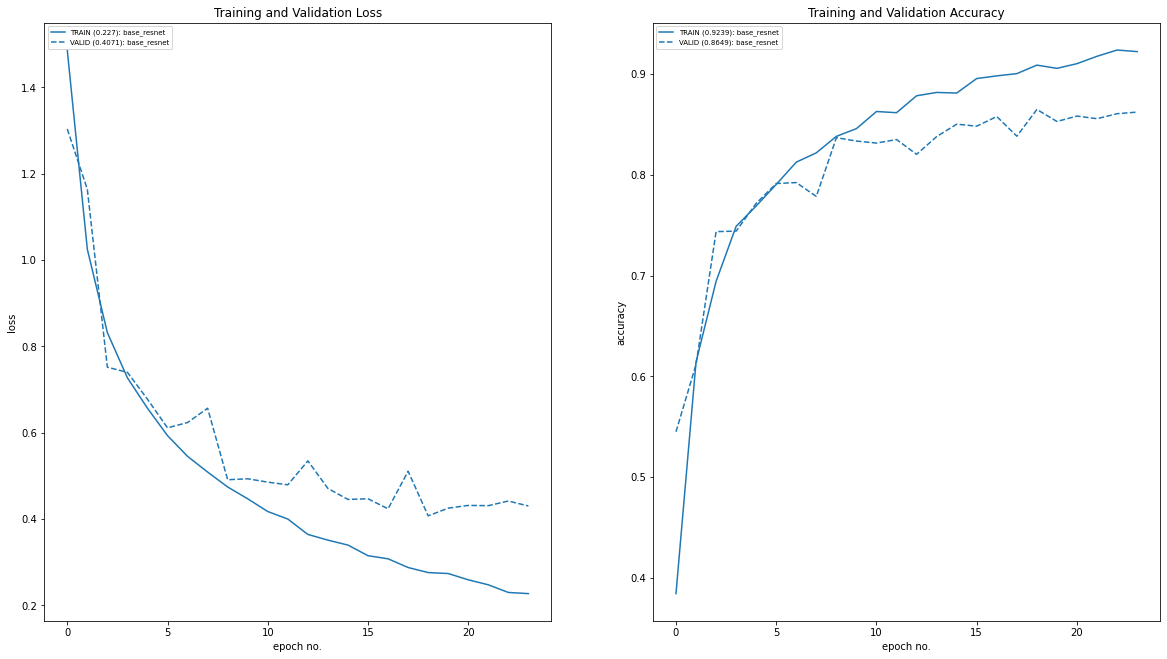

In [30]:
plt.figure(figsize=(20, 11))
plot_loss_accuracy(
    train_loss=[train_losses],
    val_loss=[test_losses],
    train_acc=[train_metrics],
    val_acc=[test_metrics],
    labels=["base_resnet"],
    colors=["blue"],
    loss_legend_loc="upper left",
    acc_legend_loc="upper left",
    legend_font=7,
)

## Advanced models with Scheduling

In [36]:
resnet_model = ResnetNetwork(in_channels=3, num_classes=num_classes).to(device)
summary(resnet_model, input_size=(1,3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
ResnetNetwork                            [1, 10]                   --
├─Sequential: 1-1                        [1, 64, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 64, 32, 32]           1,728
│    └─BatchNorm2d: 2-2                  [1, 64, 32, 32]           128
│    └─ReLU: 2-3                         [1, 64, 32, 32]           --
├─ResnetBlock: 1-2                       [1, 128, 16, 16]          --
│    └─Sequential: 2-4                   [1, 128, 16, 16]          --
│    │    └─Conv2d: 3-1                  [1, 128, 32, 32]          73,728
│    │    └─MaxPool2d: 3-2               [1, 128, 16, 16]          --
│    │    └─BatchNorm2d: 3-3             [1, 128, 16, 16]          256
│    │    └─ReLU: 3-4                    [1, 128, 16, 16]          --
│    └─Sequential: 2-5                   [1, 128, 16, 16]          --
│    │    └─Conv2d: 3-5                  [1, 128, 16, 16]          73,728
│ 

In [37]:
model, optimizer, criterion, metric, early_stopping = model_drivers(
    model=resnet_model,
    learning_rate=learning_rate,
    device=device,
    num_classes=num_classes,
    model_name="resnet_model_cyclical.pt",
)

  0%|          | 0/250 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.98E-03


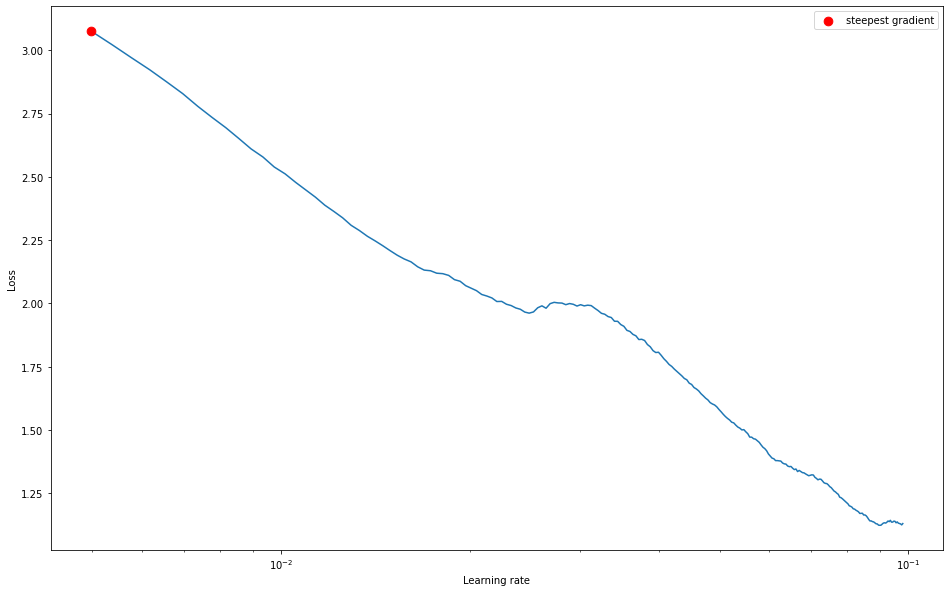

In [38]:
suggested_lr(
    model=resnet_model,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    train_loader=train_loader,
    end_lr=0.1,
    num_iter=250,
)

In [39]:
suggested_lr = 4.98E-03

In [42]:
scheduler = lr_scheduler(
    type="CyclicLR",
    optimizer=optimizer,
    max_lr=suggested_lr,
    epochs=epochs,
    steps_per_epoch=len(train_loader),
    anneal_strategy="linear",
    pct_start=0.10,
)

In [44]:
train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(0, epochs):
    print(f"Epoch {epoch}")
    train_losses, train_metrics = train_module(
        resnet_model,
        device,
        train_loader,
        optimizer,
        criterion,
        metric,
        train_losses,
        train_metrics,
    )
    test_losses, test_metrics = test_module(
        resnet_model,
        device,
        test_loader,
        criterion,
        metric,
        test_losses,
        test_metrics,
    )
    # Lr scheduler added
    scheduler.step()
    print(f"Learning rate ahead: {scheduler.get_last_lr()}")

    early_stopping(
        test_losses[-1], resnet_model, epoch
    )  # last recorded test loss to measure the improvement against the prior one
    if early_stopping.early_stop:
        print("Early stopping")
        break

Epoch 0


  0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           | 0/98 [00:00<?, ?it/s]/

Avg Train Loss: 1.5547092009563834 Avg Train Metric: 0.3540190897729932: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:10<00:00,  9.52it/s]


Learning rate ahead: [0.0002187934426229508]
Validation loss decreased (inf --> 1.229278).  Saving model ...
Epoch 1


Avg Train Loss: 1.2228180050849915 Avg Train Metric: 0.5663436472415924:  31%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        | 30/98 [00:03<00:06,  9.87it/s]